## Setup

In [23]:
%matplotlib inline
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score

In [21]:
BASE_PATH = "/content/drive/My Drive/obj tracking/"
DATASET_BASE_PATH = "/content/drive/My Drive/obj tracking/Bird species/"

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


## Helper Functions

In [4]:
def imshow(img): 
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  x = np.transpose(npimg, (1, 2, 0))
  plt.imshow(x)
  plt.show()

In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, 
                save_path, load_path=None,
                scheduler=None, n_epochs=1, valid_loss_min = np.Infinity):
  
  if load_path:
    model.load_state_dict(torch.load(load_path))

  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []

  total_step = len(train_loader)
  n_batch_print = (total_step - 1) / 3

  for epoch in range(1, n_epochs + 1): 
    since = time.time()

    running_loss = 0.0
    correct = 0
    total = 0

    model.train()

    for batch_idx, data in enumerate(train_loader): 
      # get the inputs; data is in list of [inputs, labels]
      inputs, targets = data

      # zero the parameter gradients 
      optimizer.zero_grad()

      # forward + backward + optimize 
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step() 

      # print stats
      running_loss += loss.item()

      # outputs gives C values, one for each class. we want to pick the highest
      # one which is the model's best prediction
      _, preds = torch.max(outputs, dim=1)
      correct += torch.sum(preds == targets).item()
      total += targets.size(0)

      if batch_idx % n_batch_print == 0: # print every n mini-batches
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
              .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        # running_loss = 0.0

    # step the lr_scheduler every epoch
    if scheduler:
      scheduler.step()

    # update performance stats for every epoch
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    
    # evaluate performance on validation data after each epoch
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
      model.eval()
      for inputs_t, targets_t in (val_loader):
        outputs_t = model(inputs_t)
        loss_t = criterion(outputs_t, targets_t)
        batch_loss += loss_t.item()
        _, preds_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(preds_t==targets_t).item()
        total_t += targets_t.size(0)
      val_acc.append(100 * correct_t / total_t)
      val_loss.append(batch_loss/len(val_loader))

      network_learned = batch_loss < valid_loss_min
      print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}')
      # Saving the best weight 
      if network_learned:
        print('Detected network improvement, saving current model\n')
        valid_loss_min = batch_loss
        torch.save(model.state_dict(), save_path)
      
    time_elapsed = time.time() - since
    print('Epoch completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # update lr_scheduler.step()


  print('Finished Training')
  return model, val_loss, val_acc, train_loss, train_acc, valid_loss_min

In [6]:
# helper functions for showing confusion matrix

def get_predictions(model, loader, all_data=False, iters=10):
  """Runs all data through the model to get predictions."""
  with torch.no_grad():
    model.eval()
    all_preds = []
    all_labels = []
    dataiter = iter(loader)
    for i in range(len(dataiter)):
      images, labels = dataiter.next()
      outputs = model(images)
      _, preds = torch.max(outputs, dim=1) # type Tensor
      all_labels += labels.tolist()
      all_preds += preds.tolist()

    return all_labels, all_preds

def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
  """ This function prints and plots the confusion matrix with the true labels
      on the y-axis against the predicted labels on the x-axis.
      Normalization can be applied by setting `normalize=True`.
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=80)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:np.newaxis]
    print('Normalized confusion matrix')
  else:
      print('Confusion matrix without normalization')

  color_thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])  ):
      plt.text(j, i, cm[i, j], horizontalalignment='center', 
               color='white' if cm[i, j] > color_thresh else 'black')
      
  # plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

## Data Preprocessing

In [7]:
# import data from google drive 
# note that the classes are assigned integers in alphabetical order
class_dict_orig = pd.read_csv(
    os.path.join(DATASET_BASE_PATH, "class_dict.csv"))['class'].to_dict()

metadata_orig = pd.read_csv(os.path.join(DATASET_BASE_PATH, 
                                                "Bird Species.csv"))
total_classes = len(class_dict_orig)

In [8]:
# select a subset of all our classes (faster to train)

num_classes = 20

# randomly chosen classes 
class_names = ['AMERICAN GOLDFINCH', 'AMERICAN REDSTART', 'BANDED BROADBILL', 
               'CASSOWARY', 'CHARA DE COLLAR', 'CINNAMON TEAL', 'COMMON LOON', 
               'CUBAN TROGON', 'EASTERN TOWEE', 'GLOSSY IBIS', 'GOLDEN EAGLE', 
               'HOUSE FINCH', 'IMPERIAL SHAQ', 'MALEO', 'PUFFIN', 
               'RED HONEY CREEPER', 'RED NAPED TROGON', 'TIT MOUSE', 
               'TURKEY VULTURE', 'VERMILION FLYCATHER']

class_dict = {i:class_names[i] for i in range(num_classes)}
print(class_names)
print(class_dict)

metadata_subset = metadata_orig[metadata_orig['labels'].isin(class_names)]
metadata_subset.sample(frac=1).head()

['AMERICAN GOLDFINCH', 'AMERICAN REDSTART', 'BANDED BROADBILL', 'CASSOWARY', 'CHARA DE COLLAR', 'CINNAMON TEAL', 'COMMON LOON', 'CUBAN TROGON', 'EASTERN TOWEE', 'GLOSSY IBIS', 'GOLDEN EAGLE', 'HOUSE FINCH', 'IMPERIAL SHAQ', 'MALEO', 'PUFFIN', 'RED HONEY CREEPER', 'RED NAPED TROGON', 'TIT MOUSE', 'TURKEY VULTURE', 'VERMILION FLYCATHER']
{0: 'AMERICAN GOLDFINCH', 1: 'AMERICAN REDSTART', 2: 'BANDED BROADBILL', 3: 'CASSOWARY', 4: 'CHARA DE COLLAR', 5: 'CINNAMON TEAL', 6: 'COMMON LOON', 7: 'CUBAN TROGON', 8: 'EASTERN TOWEE', 9: 'GLOSSY IBIS', 10: 'GOLDEN EAGLE', 11: 'HOUSE FINCH', 12: 'IMPERIAL SHAQ', 13: 'MALEO', 14: 'PUFFIN', 15: 'RED HONEY CREEPER', 16: 'RED NAPED TROGON', 17: 'TIT MOUSE', 18: 'TURKEY VULTURE', 19: 'VERMILION FLYCATHER'}


,filepaths,labels,data set
15280,train/EASTERN TOWEE/082.jpg,EASTERN TOWEE,train
17748,train/GLOSSY IBIS/022.jpg,GLOSSY IBIS,train
12049,train/COMMON LOON/006.jpg,COMMON LOON,train
34323,train/RED NAPED TROGON/122.jpg,RED NAPED TROGON,train
10941,train/CINNAMON TEAL/089.jpg,CINNAMON TEAL,train


In [9]:
# encode the string labels using integers
lb = LabelEncoder()
metadata_subset['encoded labels'] = lb.fit_transform(metadata_subset['labels'])

# check a sample of the data to verify that the encoded labels are correct
# metadata_subset.sample(frac=1).head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# sort the data into training, validation, and test data 
train_files = metadata_subset[metadata_subset['data set'] == 'train'].drop(columns=['data set'])
val_files = metadata_subset[metadata_subset['data set'] == 'valid'].drop(columns=['data set'])
test_files = metadata_subset[metadata_subset['data set'] == 'test'].drop(columns=['data set'])

# reset index to start at 0
train_files = train_files.reset_index(drop=True)
val_files = val_files.reset_index(drop=True)
test_files = test_files.reset_index(drop=True)

# check what the data looks like
val_files.sample(frac=1).head()

,filepaths,labels,encoded labels
39,valid/CUBAN TROGON/5.jpg,CUBAN TROGON,7
38,valid/CUBAN TROGON/4.jpg,CUBAN TROGON,7
66,valid/MALEO/2.jpg,MALEO,13
34,valid/COMMON LOON/5.jpg,COMMON LOON,6
62,valid/IMPERIAL SHAQ/3.jpg,IMPERIAL SHAQ,12


In [11]:
# define a transform function to transform image data into a tensor, then
# normalize btwn range [-1, 1]

transform_basic = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [12]:
# define a DataSet class to store our data 

class Bird_Dataset(Dataset): 
  def __init__(self, img_data, img_path, train=False, transform_basic=None, transform_augment=None):
    """ arguments:  img_data, DataFrame w/ file path, label, and encoded label
                    img_path, path to root folder of folders
                    transform, data transformation operation(s) to apply to raw
                      image data
    """
    self.img_data = img_data
    self.img_path = img_path
    self.is_train = train
    self.transform_basic = transform_basic
    self.transform_augment = transform_augment

  def __len__(self):
    return len(self.img_data)

  def __getitem__(self, index):
    """returns the data and labels in a tuple"""
    img_name = os.path.join(self.img_path, self.img_data.loc[index, 'filepaths'])
    # img_name = os.path.join(self.img_path, self.img_data['filepaths'][index])
    image = Image.open(img_name)
    # optional, can resize images here (or in the transformation pipeline). 
    # bird images are currently 224 x 224, no need to resize
    # image = image.resize((224, 224)) 
    label = torch.tensor(self.img_data.loc[index, 'encoded labels'])
    
    if self.is_train and self.transform_augment is not None:
      image = self.transform_augment(image)
    if self.transform_basic is not None: 
      image = self.transform_basic(image)
    return image, label

In [13]:
# create a Bird_Dataset object for each of our train, val, and test data

train_set = Bird_Dataset(train_files, DATASET_BASE_PATH, train=True, 
                         transform_basic=transform_basic)
val_set = Bird_Dataset(val_files, DATASET_BASE_PATH,
                       transform_basic=transform_basic)
test_set = Bird_Dataset(test_files, DATASET_BASE_PATH,
                        transform_basic=transform_basic)

In [14]:
# create DataLoaders, which can then iterate over our data 
batch_size = 128

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

## Visualize Data

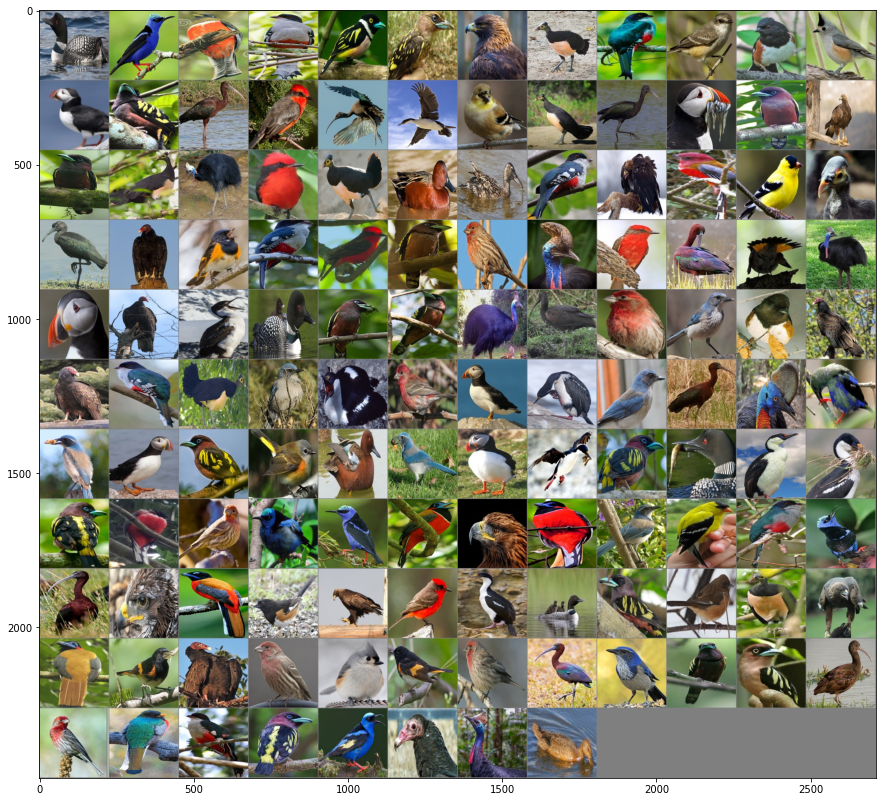

COMMON LOON; RED HONEY CREEPER; RED NAPED TROGON; CUBAN TROGON; BANDED BROADBILL; BANDED BROADBILL; GOLDEN EAGLE; MALEO; CUBAN TROGON; VERMILION FLYCATHER; EASTERN TOWEE; TIT MOUSE; PUFFIN; BANDED BROADBILL; GLOSSY IBIS; VERMILION FLYCATHER; GLOSSY IBIS; IMPERIAL SHAQ; AMERICAN GOLDFINCH; MALEO; GLOSSY IBIS; PUFFIN; BANDED BROADBILL; GOLDEN EAGLE; BANDED BROADBILL; MALEO; CASSOWARY; VERMILION FLYCATHER; MALEO; CINNAMON TEAL; CINNAMON TEAL; CUBAN TROGON; GOLDEN EAGLE; RED NAPED TROGON; AMERICAN GOLDFINCH; MALEO; GLOSSY IBIS; TURKEY VULTURE; AMERICAN REDSTART; CUBAN TROGON; VERMILION FLYCATHER; BANDED BROADBILL; HOUSE FINCH; CASSOWARY; VERMILION FLYCATHER; GLOSSY IBIS; AMERICAN REDSTART; CASSOWARY; PUFFIN; TURKEY VULTURE; IMPERIAL SHAQ; COMMON LOON; BANDED BROADBILL; BANDED BROADBILL; CASSOWARY; GLOSSY IBIS; HOUSE FINCH; CHARA DE COLLAR; EASTERN TOWEE; TURKEY VULTURE; TURKEY VULTURE; CUBAN TROGON; MALEO; CHARA DE COLLAR; IMPERIAL SHAQ; HOUSE FINCH; PUFFIN; IMPERIAL SHAQ; CHARA DE COLLAR;

In [15]:
# visualize image data: 
# get rand training imgs 

dataiter = iter(train_loader)
images, labels = dataiter.next() # gets [batch_size] number of images and labels 
fig = plt.figure(figsize=(15,15))
imshow(torchvision.utils.make_grid(images, nrow=12))
print('; '.join('%5s' % class_dict[labels[j].item()] for j in range(batch_size)))

## Define architecture of our neural network using transfer learning

In [18]:
model = models.alexnet(pretrained=True)

# we don't need to train the earlier layers of AlexNet; we can simply use it out
# of the box
for name, param in model.named_parameters():
  # print(name)
  param.requires_grad = False

# replace the last layer in AlexNet so that we can train it
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [24]:
# define loss function 
criterion = nn.CrossEntropyLoss()

# define optimizer 
# optimizer = optim.SGD(midnet.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define learning rate scheduler
epoch_steps = 7
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=epoch_steps, 
                                        gamma=0.1)

## Train the neural net

In [25]:
bird_transfer_param_path = os.path.join(DATASET_BASE_PATH, 
                                                'alexnet_bird_params.pt')

In [26]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []

In [38]:
# model performance peaked around epoch 3; trained for total of 13 epochs
model, val_loss_prog, val_acc_prog, train_loss_prog, train_acc_prog, valid_loss_min = train_model(
    model, criterion, optimizer, train_loader, val_loader, 
    save_path=bird_transfer_param_path, scheduler=step_lr_scheduler, n_epochs=5, 
    valid_loss_min=valid_loss_min)
  
val_loss += val_loss_prog
val_acc += val_acc_prog
train_loss += train_loss_prog
train_acc += train_acc_prog

Epoch [1/5], Step [0/23], Loss: 0.0465

train loss: 0.0661, train acc: 98.6878
validation loss: 0.1096, validation acc: 98.0000
Epoch completed in 1m 40s
Epoch [2/5], Step [0/23], Loss: 0.0707

train loss: 0.0635, train acc: 98.9641
validation loss: 0.1083, validation acc: 98.0000
Epoch completed in 1m 40s
Epoch [3/5], Step [0/23], Loss: 0.0911

train loss: 0.0627, train acc: 98.8260
validation loss: 0.1075, validation acc: 98.0000
Epoch completed in 1m 38s
Epoch [4/5], Step [0/23], Loss: 0.0312

train loss: 0.0613, train acc: 99.1713
validation loss: 0.1072, validation acc: 98.0000
Epoch completed in 1m 37s
Epoch [5/5], Step [0/23], Loss: 0.0367

train loss: 0.0603, train acc: 99.2058
validation loss: 0.1073, validation acc: 98.0000
Epoch completed in 1m 37s
Finished Training


## Examine model performance

Confusion matrix without normalization
val accuracy:  0.98


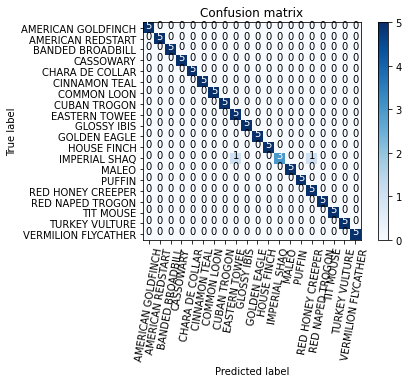

In [43]:
val_true, val_pred = get_predictions(model=model, loader=val_loader)

val_acc_score = accuracy_score(y_true=val_true, y_pred=val_pred)
cm = confusion_matrix(y_true=val_true, y_pred=val_pred)

cm_plot_labels = class_names

plot_confusion_matrix(cm=cm, classes=cm_plot_labels)
print('val accuracy: ', val_acc_score)

Confusion matrix without normalization
test accuracy:  0.97


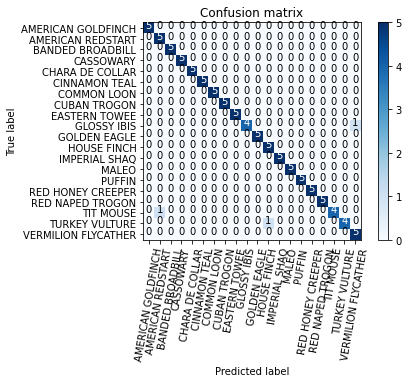

In [44]:
test_true, test_pred = get_predictions(model=model, loader=test_loader)

test_acc_score = accuracy_score(y_true=test_true, y_pred=test_pred)
test_cm = confusion_matrix(y_true=test_true, y_pred=test_pred)

cm_plot_labels = class_names

plot_confusion_matrix(cm=test_cm, classes=cm_plot_labels)
print('test accuracy: ', test_acc_score)

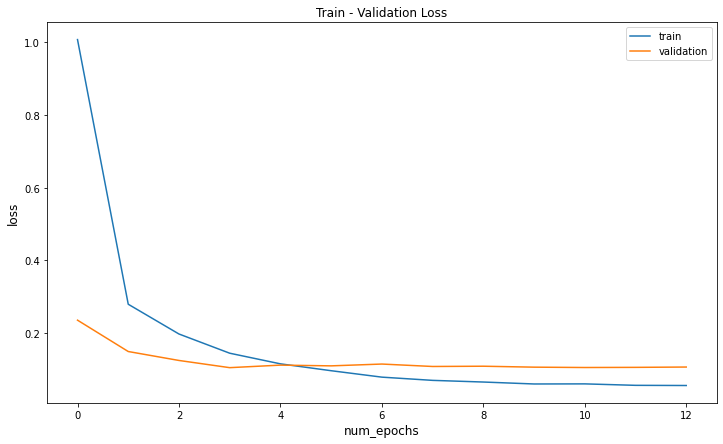

In [45]:
fig = plt.figure(figsize=(12,7))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

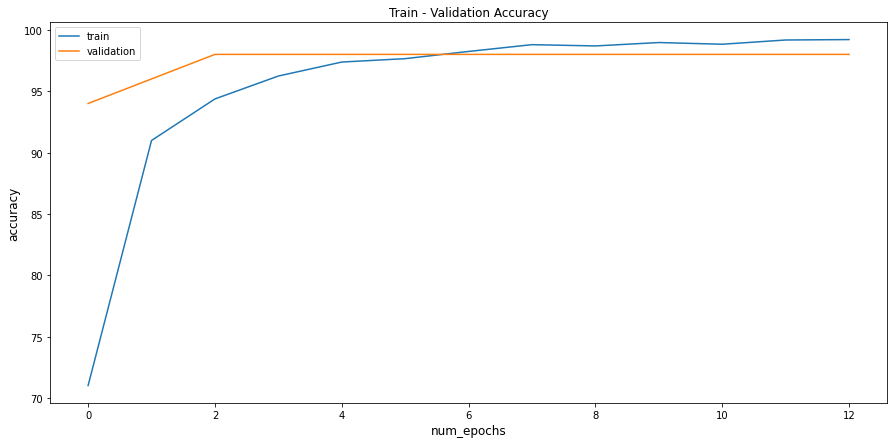

In [46]:
fig = plt.figure(figsize=(15,7))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.show()